<a href="https://colab.research.google.com/github/ncku28001349/test1/blob/main/%E3%80%8CAI_SensorMLP0625_ipynb%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This step check if GPU available

In [ ]:
import torch
torch.cuda.is_available()

import tensorflow as tf
tf.test.gpu_device_name()
print(tf.__version__)

2.15.0


# Data Preprocessing Steps
1. Get Data from github
2. Applied preprocessing method
3. Data partition for independent test 獨立測試的資料分區


In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout , Flatten , LSTM , GRU , Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import statistics

from numpy.lib.function_base import average
import math
import itertools
from keras.callbacks import LearningRateScheduler
from tensorflow.keras import activations


def normalize(Data , y_dim):
    for i in range(Data.shape[1] - y_dim):
        std = Data.iloc[: , [i]].std()
        mean = Data.iloc[: , [i]].mean()
        Data.iloc[: , [i]] = (Data.iloc[: , [i]] - mean) / std
    return Data

def BuildTrain(X , Y , past):
    X_temp = []
    Y_temp = []
    for i in range(X.shape[0] - 1 - past):
        X_temp.append(np.array(X.iloc[i : i + past , 0 : X.shape[1]]))
        Y_temp.append(np.array([Y['H2S(GT)'][i + past - 1] , Y['TVOC(GT)'][i + past - 1] , Y['CO(GT)'][i + past - 1] , Y['SO2(GT)'][i + past - 1] , Y['Nox(GT)'][i + past - 1]]))
        #Y_train.append(np.array(data.iloc[i+past:i+past+1][['CO(GT)']]))
        #Y_train.append(np.array(data.iloc[i+past:i+past+1][['NOx(GT)']]))
        #temp.append(np.array([data['CO(GT)'][i+past], data['NOx(GT)'][i+past], data['NO2(GT)'][i+past]]))
    return np.array(X_temp) , np.array(Y_temp)

def Draw(history):
    fig = plt.figure()
    plt.plot(history.history['loss'] , label = 'training loss' , color = 'blue')
    plt.plot(history.history['val_loss'] , label = 'val loss' , color = 'red')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='upper right')
    fig.savefig('./loss.png')


mtraining_loss = []  # 損失函數（loss function）又叫做代價函數（cost function），是用來評估模型的預測值與真實值不一致的程度，
             # 也是神經網絡中優化的目標函數，神經網絡訓練或者優化的過程就是最小化損失函數的過程，損失函數越小，
             # 說明模型的預測值就越接近真實值，模型的健壯性也就越好。
mmae = []       # 平均 平均絕對誤差 做5次平均絕對誤差 再全部加總平均一次
mmse = []       # 平均 平均平方誤差
mrmse = []      # 平均 均方根誤差
mr2 = []       # 平均 決定係數
mstd = []       # 平均標準差
mmre = []       # 平均 平均相對誤差

def Check_error(pred, test):
  global mmae, mmse, mrmse, mr2, mstd, training_loss

  mae = np.mean(np.abs(test - pred) , axis = 0)    # 平均絕對誤差
  mse = np.mean((test - pred)**2 , axis = 0)      # 平均平方誤差
  rmse = np.sqrt(mse)                 # 均方根誤差
  r2 = np.array([r2_score(test[: , i] , pred[: , i]) for i in range(test.shape[1])])  #決定係數
  std = np.std(test - pred , axis = 0)        # 標準差
  #mre = mae / (np.sum(test , axis = 0) / len(test))
  mre = mae / (np.sum(test , axis = 0) / 3000)      # 平均相對誤差

  mmae.append(mae.tolist())
  mmse.append(mse.tolist())
  mrmse.append(rmse.tolist())
  mr2.append(r2.tolist())
  mstd.append(std.tolist())
  mmre.append(mre.tolist())

  mmae_out = np.mean(mmae , axis = 0).tolist()
  mmse_out = np.mean(mmse , axis = 0).tolist()
  mrmse_out = np.mean(mrmse , axis = 0).tolist()
  mr2_out = np.mean(mr2 , axis = 0).tolist()
  mstd_out = np.mean(mstd , axis = 0).tolist()
  mmre_out = np.mean(mmre , axis = 0).tolist()

  print("mae of H2S:",round(mmae_out[0],3), "ppm")   # 平均絕對誤差
  print("mae of TVOC:",round(mmae_out[1],3), "ppm")
  print("mae of CO:",round(mmae_out[2],3), "ppm")
  print("mae of SO2:",round(mmae_out[3],3), "ppb")
  print("mae of NOx:",round(mmae_out[4],3), "ppb")

  print("mse of H2S:",round(mmse_out[0],3), "ppm")    # 平均平方誤差
  print("mse of TVOC:",round(mmse_out[1],3), "ppm")
  print("mse of CO:",round(mmse_out[2],3), "ppm")
  print("mse of SO2:",round(mmse_out[3],3), "ppb")
  print("mse of NOx:",round(mmse_out[4],3), "ppb")

  print("rmse of H2S:",round(mrmse_out[0],3), "ppm")   # 均方根誤差
  print("rmse of TVOC:",round(mrmse_out[1],3), "ppm")
  print("rmse of CO:",round(mrmse_out[2],3), "ppm")
  print("rmse of SO2:",round(mrmse_out[3],3), "ppb")
  print("rmse of NOx:",round(mrmse_out[4],3), "ppb")

  print("r2 of H2S:",round(mr2_out[0],3), "%")
  print("r2 of TVOC:",round(mr2_out[1],3), "%")
  print("r2 of CO:",round(mr2_out[2],3), "%")
  print("r2 of SO2:",round(mr2_out[3],3), "%")
  print("r2 of NOx:",round(mr2_out[4],3), "%")

  print("std of H2S:",round(mstd_out[0],3), "ppm")    # 標準差
  print("std of TVOC:",round(mstd_out[1],3), "ppm")
  print("std of CO:",round(mstd_out[2],3), "ppm")
  print("std of SO2:",round(mstd_out[3],3), "ppb")
  print("std of NOx:",round(mstd_out[4],3), "ppb")

  print("mre of H2S:",round(mmre_out[0],3), "ppm")    # 平均相對誤差
  print("mre of TVOC:",round(mmre_out[1],3), "ppm")
  print("mre of CO:",round(mmre_out[2],3), "ppm")
  print("mre of SO2:",round(mmre_out[3],3), "ppb")
  print("mre of NOx:",round(mmre_out[4],3), "ppb")

  print("training loss:",round(np.mean(mtraining_loss),4))   # 訓練誤差


def Gas_Predict(predicted_data, actual_result, start_point, window, fig_name):

    pred_H2S = []
    act_H2S = []
    pred_TVOC = []
    act_TVOC = []
    pred_CO = []
    act_CO = []
    pred_SO2 = []
    act_SO2 = []
    pred_NOx = []
    act_NOx = []

    x_labels = []

    for i in range (start_point , start_point + window):

        x_labels.append(i)
        pred_H2S.append(predicted_data[i][0])
        act_H2S.append(actual_result[i][0])
        pred_TVOC.append(predicted_data[i][1])
        act_TVOC.append(actual_result[i][1])
        pred_CO.append(predicted_data[i][2])
        act_CO.append(actual_result[i][2])
        pred_SO2.append(predicted_data[i][3])
        act_SO2.append(actual_result[i][3])
        pred_NOx.append(predicted_data[i][4])
        act_NOx.append(actual_result[i][4])

    fig = plt.figure()
    plt.plot(x_labels , act_H2S , color = 'blue' , label = 'Real H2S')
    plt.plot(x_labels , pred_H2S , color = 'blue' , linestyle = 'dashed' , label = 'Prediction H2S')
    plt.title('H2S' , fontsize = 18)
    plt.xlabel('prediction point(hour)' , fontsize = 16)
    plt.ylabel('H2S concentration(ppm)' , fontsize = 16)
    plt.legend()
    fig.savefig('./' + fig_name + '_H2S.svg')

    fig = plt.figure()
    plt.plot(x_labels , act_TVOC , color = 'blue' , label = 'Real TVOC')
    plt.plot(x_labels , pred_TVOC , color = 'blue' , linestyle = 'dashed' , label = 'Prediction TVOC')
    plt.title('TVOC', fontsize = 18)
    plt.xlabel('prediction point(hour)' , fontsize = 16)
    plt.ylabel('TVOC concentration(ppm)' , fontsize = 16)
    plt.legend()
    fig.savefig('./' + fig_name + '_TVOC.svg')

    fig = plt.figure()
    plt.plot(x_labels , act_CO , color = 'blue' , label = 'Real CO')
    plt.plot(x_labels , pred_CO , color = 'blue' , linestyle = 'dashed' , label = 'Prediction CO')
    plt.title('CO' , fontsize = 18)
    plt.xlabel('prediction point(hour)' , fontsize = 16)
    plt.ylabel('CO concentration(ppm)' , fontsize = 16)
    plt.legend()
    fig.savefig('./' + fig_name + '_CO.svg')

    fig = plt.figure()
    plt.plot(x_labels , act_SO2 , color = 'blue' , label = 'Real SO2')
    plt.plot(x_labels , pred_SO2 , color = 'blue' , linestyle = 'dashed' , label = 'Prediction SO2')
    plt.title('SO2' , fontsize = 18)
    plt.xlabel('prediction point(hour)' , fontsize = 16)
    plt.ylabel('SO2 concentration(ppb)' , fontsize = 16)
    plt.legend()
    fig.savefig('./' + fig_name + '_SO2.svg')

    fig = plt.figure()
    plt.plot(x_labels, act_NOx , color = 'blue' , label = 'Real NOx')
    plt.plot(x_labels, pred_NOx , color = 'blue' , linestyle = 'dashed' , label = 'Prediction NOx')
    plt.title('NOx',fontsize = 18)
    plt.xlabel('prediction point(hour)' , fontsize = 16)
    plt.ylabel('NOx concentration(ppb)' , fontsize = 16)
    plt.legend()
    fig.savefig('./' + fig_name + '_NOx.svg')

def lr_step_decay(epoch, lr):
    drop_rate = 0.85
    epochs_drop = 4.0
    return initial_learning_rate * math.pow(drop_rate , math.floor(epoch / epochs_drop))

def Draw_loss(training_loss, val_loss):
    fig = plt.figure()
    plt.plot(training_loss , label = 'training loss' , color = 'blue')
    plt.plot(val_loss , label = 'val loss' , color = 'red')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc = 'upper right')
    fig.savefig('./loss.svg')

Data_url = "https://raw.githubusercontent.com/xxiex123/mox-gas-sensor-/main/data(1121215-11301).csv"

#remove column and row contain frequently missing value
df = pd.read_csv(Data_url)


#linear intepolation for missing value
df = df.replace(-200.0 , np.nan)

df = df.interpolate(method = 'linear')
print(df)

#data partition for independent test
df_2 = df.iloc[1050 : 1100 , :]
df = df.iloc[:1050 , :]

print("Shape of new dataframes - {} , {}".format(df.shape , df_2.shape))

df_MLP = df
X = df_MLP.iloc[: , 0 : df_MLP.shape[1] - 5]
Y = df_MLP.iloc[: , df_MLP.shape[1] - 5 : df_MLP.shape[1]]

# normailization
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X.iloc[: , 0 : X.shape[1]] = scaler_X.fit_transform(X.iloc[: , 0 : X.shape[1]].to_numpy())
Y.iloc[: , 0 : Y.shape[1]] = scaler_Y.fit_transform(Y.iloc[: , 0 : Y.shape[1]].to_numpy())

print("after norm:")
print("X = \n" , X)
print("Y = \n" , Y)

X = X.to_numpy()
Y = Y.to_numpy()


         H2S    TVOC      CO     SO2    Nox    RH     T  H2S(GT)  TVOC(GT)  \
0     1991.0  1704.0  1612.0  1419.0  776.0  65.2  25.8     2.32      2.50   
1     2203.0  2053.0  2024.0  1544.0  820.0  60.8  32.8     2.32      2.50   
2     2272.0  2194.0  2177.0  1622.0  851.0  52.5  36.7     2.36      2.55   
3     2310.0  2288.0  2298.0  1582.0  894.0  41.9  43.1     2.36      2.59   
4     2322.0  2291.0  2318.0  1566.0  899.0  39.7  42.8     2.45      2.64   
...      ...     ...     ...     ...    ...   ...   ...      ...       ...   
1147  3078.0  3015.0  3287.0   959.0  861.0  46.9  21.6     2.26      2.28   
1148  3068.0  3010.0  3281.0   963.0  857.0  46.7  21.5     2.31      2.40   
1149  3072.0  3005.0  3279.0   953.0  846.0  46.5  21.1     2.31      2.43   
1150  3073.0  3005.0  3279.0   949.0  847.0  46.4  20.9     2.41      2.52   
1151  3064.0  3003.0  3277.0   964.0  835.0  46.4  20.5     2.35      2.45   

      CO(GT)  SO2(GT)  Nox(GT)  
0       0.51      4.1     13.5

# Check std and mean for normalization 標準差  平均值  X:感測器值  Y:測站儀器值

In [ ]:
mean_X = scaler_X.mean_
std_X = scaler_X.scale_
mean_Y = scaler_Y.mean_
std_Y = scaler_Y.scale_

print(mean_X)
print(std_X)
print(mean_Y)
print(std_Y)

[1810.17285714 1477.05285714 1318.12       1086.67142857  572.00190476
   47.48880952   25.39757143]
[137.17550412 200.33691222 228.95289364 166.33512827 133.60843563
   8.39522035   6.89037744]
[ 2.2740381   2.40419048  0.41709524  2.852      20.79390476]
[0.15845227 0.20025594 0.09624097 1.01109125 8.01423026]


# Data preprocessing for the independent test data

In [ ]:
df_2.index = np.arange(0, len(df_2) )

new_X = df_2.iloc[: , 0 : df_2.shape[1] - 5]    #感測器原值

new_Y = df_2.iloc[: , df_2.shape[1] - 5 : df_2.shape[1]]    #公13測站儀器值

#normalization
new_X.iloc[: , 0 : new_X.shape[1]] = scaler_X.transform(new_X.iloc[: , 0 : new_X.shape[1]].to_numpy())

print("after norm:")
print("new X = \n" , new_X)
print("new Y = \n" , new_Y)

new_X = new_X.to_numpy()
new_Y = new_Y.to_numpy()

after norm:
new X = 
          H2S      TVOC        CO       SO2       Nox        RH         T
0   0.450716  0.663618  1.213699 -1.903816  1.968424 -0.391748 -1.131661
1   0.406976  0.618693  1.170022 -1.879768  1.863641 -0.403659 -1.189713
2   0.363236  0.578761  1.148184 -1.915840  1.848671 -0.415571 -1.218739
3   0.290337  0.548811  1.091404 -1.927864  1.758857 -0.463217 -1.189713
4   0.275757  0.528845  1.073933 -1.945899  1.751372 -0.451306 -1.233252
5   0.290337  0.528845  1.052094 -1.861732  1.706465 -0.427482 -1.247765
6   0.472585  0.633668  1.065197 -1.513038  1.788795 -0.439394 -1.102635
7   0.939141  0.913197  1.209332 -0.857735  1.871125 -0.522775 -0.696271
8   1.471306  1.267600  1.423350 -0.220467  2.118115 -0.868209  0.537333
9   1.682714  1.422340  1.567484  0.044059  2.305229 -0.939679  0.943697
10  1.974311  1.646961  1.746560  0.194358  2.544735 -1.011148  1.408113
11  1.981601  1.597045  1.711618  0.128227  2.597127 -0.939679  1.393600
12  2.251329  1.751785  1.798

# MLP Model training step


mtraining_loss = []
mmae = []
mmse = []
mrmse = []
mr2 = []
mstd = []
mmre = []
wd = 30

for i in range(1):

  initial_learning_rate = 0.01

  optimizer = tf.optimizers.Adam(learning_rate = initial_learning_rate)
  model = Sequential()
  model.add(Dense(wd, input_shape=(7, ), activation='relu'))
  #model.add(Dense(wd, activation='relu'))
  model.add(Dense(5, name='output'))

  loss_reduction = "sum"

  loss_fn = tf.keras.losses.MeanAbsoluteError()

  num_folds = 5
  kf = KFold(n_splits=num_folds, shuffle=True)

# 初始化一个列表来保存每个 fold 的训练结果
  fold_scores = []
  training_loss = []
  val_loss = []
  fold_predictions = []
  fold_ground_truth = []
# 进行交叉验证
  for fold, (train_index, val_index) in enumerate(kf.split(X, Y)):
    print(f"Training on fold {fold+1}...")

    # 创建当前 fold 的训练集和验证集
    X_train, X_val = X[train_index], X[val_index]
    Y_train, Y_val = Y[train_index], Y[val_index]

    # 编译模型
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['mse'])

    # 训练模型
    Epoch = 30

    history = model.fit(X_train, Y_train, epochs= Epoch, batch_size=70,validation_data=(X_val,Y_val), verbose=0, callbacks=[LearningRateScheduler(lr_step_decay, verbose=0)])
    training_loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    fold_predictions.extend(model.predict(X_val))
    fold_ground_truth.extend(Y_val)
    # 评估模型在验证集上的性能
    _, mae = model.evaluate(X_val, Y_val, verbose=0)
    fold_scores.append(mae)
    print(f"Fold {fold+1} - Validation mae: {mae}")


# 打印 5 折交叉验证的结果
  print("Cross-validation results:")
  for fold, mae in enumerate(fold_scores):
    print(f"Fold {fold+1} - Validation mae: {mae}")
  print(f"Validation mae: {np.mean(fold_scores)}")
  mtraining_loss.append(np.mean(fold_scores))

  # draw training loss
  Draw_loss(list(itertools.chain.from_iterable(training_loss)), list(itertools.chain.from_iterable(val_loss)))

  # model summarry
  model.summary()
  tf.keras.utils.plot_model(model, show_shapes=True, to_file='model.png')

  # model evaluation
  Gas_Predict(scaler_Y.inverse_transform(fold_predictions) , scaler_Y.inverse_transform(fold_ground_truth), 800, 50, 'validation test')
  #Gas_Predict(inv_pred_for_inference , new_Y, 0, 100, 'Independent Test')
  pred_for_inference = model.predict(new_X)
  inv_pred_for_inference = scaler_Y.inverse_transform(pred_for_inference)
  Check_error(inv_pred_for_inference , new_Y)

# save model
tf.keras.models.save_model(model, "/content/model.h5", include_optimizer=False)

# Convert the MLP model to Tflite model

In [ ]:
def representative_dataset():
  for rep_i in range (800):
    temp = X[rep_i]
    temp = np.expand_dims(temp,0)
    yield [temp.astype(np.float32)]

run_model = tf.function(lambda x: model(x))

BATCH_SIZE = 1
STEPS = 5
INPUT_SIZE = 7
concrete_func = run_model.get_concrete_function(tf.TensorSpec([BATCH_SIZE, INPUT_SIZE], model.inputs[0].dtype))
MODEL_DIR = "MLP_keras"

model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#converter.inference_input_type = tf.int8  # or tf.uint8
#converter.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = converter.convert()

open('/content/MLP_AISensor.tflite', 'wb').write(tflite_quant_model)

2368

# Check the performance after model conversion

[-0.7259797  -0.70329285  0.26089895  0.35164642 -0.34030297]
[[ 2.15900496  2.26335191  0.44220441  3.20754662 18.06663837]
 [ 2.16080236  2.26562351  0.44657122  3.15020037 17.7939118 ]
 [ 2.16439715  2.27243827  0.45312143  3.16166963 18.33936494]
 [ 2.15720757  2.26562351  0.44984633  3.26489284 18.43027395]
 [ 2.15361278  2.26335191  0.45639655  3.25342358 18.43027395]
 [ 2.16080236  2.26562351  0.45202973  3.13873114 17.7939118 ]
 [ 2.19315542  2.29288258  0.44875462  2.82906151 16.61209628]
 [ 2.25606417  2.36557345  0.45421314  2.3702917  15.61209879]
 [ 2.30459377  2.45189386  0.46949698  2.38176093 24.70298668]
 [ 2.30639116  2.45643704  0.46076336  2.20972227 24.52116889]
 [ 2.31358073  2.4655234   0.45421314  2.15237605 24.70298668]
 [ 2.31358073  2.46325181  0.45530484  2.08356053 24.70298668]
 [ 2.33514945  2.48823929  0.45639655  2.14090675 24.1575333 ]
 [ 2.29920159  2.45643704  0.46840528  2.29000695 27.24843552]
 [ 2.31178334  2.47006658  0.48587253  2.50792264 25.066

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


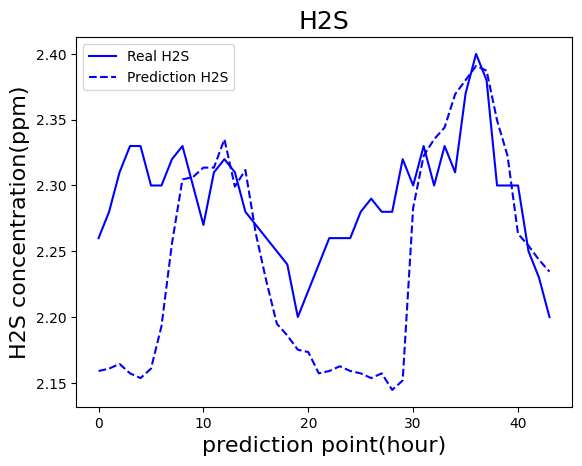

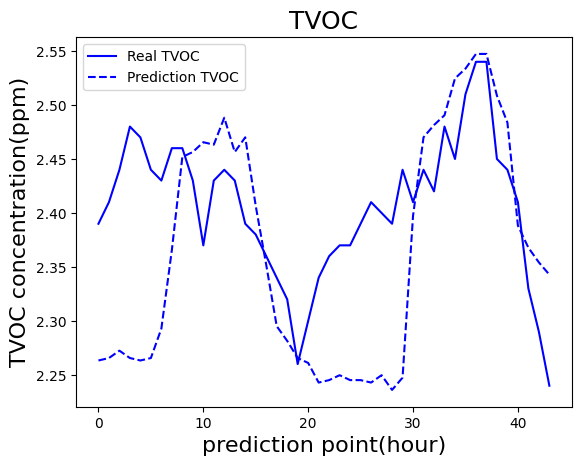

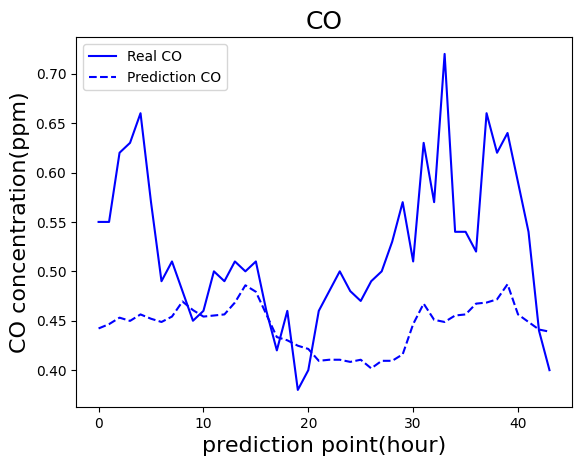

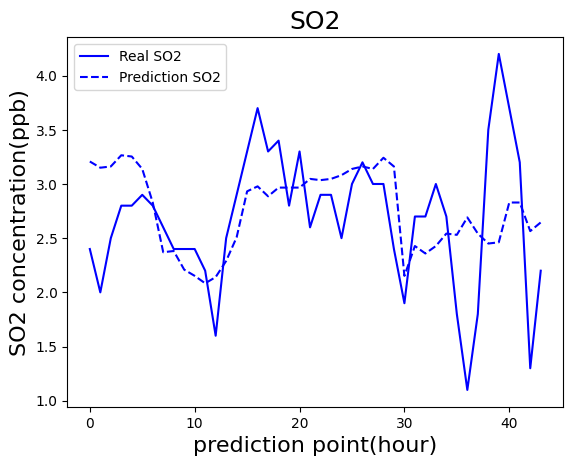

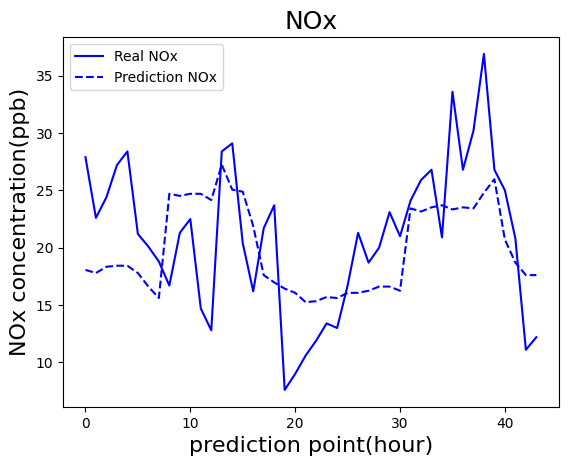

In [ ]:
interpreter = tf.lite.Interpreter('/content/MLP_AISensor.tflite')
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

lite_input = new_X.astype('float32')
lite_output = []

for i in range (lite_input.shape[0]):
  x_lite_test_expanded = np.expand_dims(lite_input[i], axis=0)
  interpreter.set_tensor(input_details[0]['index'], x_lite_test_expanded)
  interpreter.invoke()
  output_data = interpreter.get_tensor(output_details[0]['index'])
  lite_output.append(output_data[0])

print(lite_output[0])

inv_lite = scaler_Y.inverse_transform(lite_output)

print(inv_lite)
Gas_Predict(inv_lite , new_Y, 0, 44, 'lite_Predict')
#Gas_Predict(lite_output , y_test_cont, 100, 'lite_Predict')

mtraining_loss = []
mmae = []
mmse = []
mrmse = []
mr2 = []
mstd = []
mmre = []
Check_error(inv_lite , new_Y)

# Convert the Tflite model to C header file for microcontroller

In [ ]:
!apt-get install xxd
!xxd -i MLP_AISensor.tflite > MLP_AISensor.h

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xxd is already the newest version (2:8.2.3995-1ubuntu2.17).
xxd set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
xxd: MLP_AISensor.tflite: No such file or directory
